# KNN Classification

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import random

import seaborn as sns
plt.style.use('fivethirtyeight')


In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [3]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import pickle

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score #ordinary linear regression + w/ ridge regularization

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [5]:
def get_metrics(m):
    y_predict = m.predict(X_test_scaled)
    print("Model name:",m)
    print("Default threshold:")
    print("Score: {:6.4f}, Precision: {:6.4f}, Recall: {:6.4f}, F1: {:6.4f}".format(m.score(X_test_scaled, ytest),
                                                                                    precision_score(ytest, y_predict), 
                                                                                    recall_score(ytest, y_predict),
                                                                                    f1_score(ytest, y_predict)))

***

In [6]:
Xy = pd.read_pickle('data_for_regression_20k.pkl')

In [8]:
y_bi = Xy['country_USA_World_bi']
y_mlt = Xy['country_dest_id']   
X = Xy.drop(['country_dest_id','country_USA_World_bi'], axis = 1)

In [9]:
#Xy.describe()
nan_rows = X[X.isnull().any(1)]
len(nan_rows)/len(X)

0.0

In [10]:
y_bi.value_counts()/y_bi.value_counts().sum()

0.0    0.74553
1.0    0.25447
Name: country_USA_World_bi, dtype: float64

In [11]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y_bi, test_size=0.2, stratify=y_bi,random_state = 88)

In [12]:
print('X',len(X),'Xtrain', len(Xtrain), int((len(Xtrain)/len(X))*100), 
      'Xtest', len(Xtest), int((len(Xtest)/len(X))*100))

X 21366 Xtrain 17092 79 Xtest 4274 20


## 2. KNN

Steps:  
a. Scale Xtrain/Xtest  
b. Gridsearch CV best parameters (Number of neighbors) using  class balancing option  
c. Test other class balancing methods using optimal K  
d. Play with different probability thresholds for classification

### *a. Scale Xtrain and Xtest*

In [13]:
std_scale = StandardScaler()

X_train_scaled = std_scale.fit_transform(Xtrain)
X_test_scaled = std_scale.transform(Xtest)


### *b. Gridsearch CV best parameters*

In [14]:
len(Xtrain)

17092

In [15]:
#, 'weights':['uniform','distance']
grid={"n_neighbors":np.arange(8)+1}
knn=KNeighborsClassifier()
knn_cv=GridSearchCV(knn, grid, cv=3, scoring = 'recall')
knn_cv.fit(X_train_scaled, ytrain)

print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'n_neighbors': 1}
accuracy : 0.2773059211648787


In [16]:
get_metrics(knn_cv)

Model name: GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)
Default threshold:
Score: 0.2619, Precision: 0.2808, Recall: 0.2619, F1: 0.2710


In [17]:
import pickle

# Dump the trained decision tree classifier with Pickle
knn_cv_pkl_filename = 'models/knn_cv_20k.pkl'
# Open the file to save as pkl file
knn_cv_model_pkl = open(knn_cv_pkl_filename, 'wb')

#pickle.dump(logreg_cv, logreg_cv_model_pkl)
# OR???
pickle.dump(knn_cv, knn_cv_model_pkl)

# Close the pickle instances
knn_cv_model_pkl.close()

### *c. Define, fit, score model with best parameters*

In [18]:
model = KNeighborsClassifier(n_neighbors = 1)
knn_cv_best = model.fit(X_train_scaled, ytrain)
knn_cv_best.score(X_test_scaled, ytest)
get_metrics(knn_cv_best)

Model name: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')
Default threshold:
Score: 0.6413, Precision: 0.2808, Recall: 0.2619, F1: 0.2710


*How this performs on the training data*  
*This is not really significant with KNN*

*Hos this performs on the test data*

In [19]:
y_predict = knn_cv_best.predict(X_test_scaled)

In [20]:
knn_cv_best.score(X_test_scaled, ytest)

0.6413196069255966

In [21]:
recall_score(ytest, y_predict)

0.2619485294117647

### ^Best KNN model is 60% accurate but only picks up <30% of potential EU travellers^

In [45]:
"""
probs=np.arange(0.,1.1,0.1)
for p in probs:
    #knn_pp = knn_cv_best.fit(X_adasyn, y_adasyn)
    y_pred_knn = knn_cv_best.predict_proba(X_test_scaled)[:,1] > p
    print(p,recall_score(ytest, y_pred_knn))
"""

'\nprobs=np.arange(0.,1.1,0.1)\nfor p in probs:\n    #knn_pp = knn_cv_best.fit(X_adasyn, y_adasyn)\n    y_pred_knn = knn_cv_best.predict_proba(X_test_scaled)[:,1] > p\n    print(p,recall_score(ytest, y_pred_knn))\n'

In [22]:
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(ytest, knn_cv_best.predict_proba(X_test_scaled)[:,1])

ROC AUC score =  0.5164105484472509


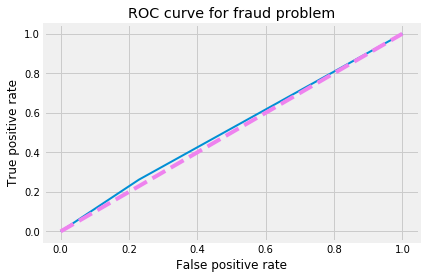

In [23]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for fraud problem');
print("ROC AUC score = ", roc_auc_score(ytest, knn_cv_best.predict_proba(X_test_scaled)[:,1]))

***

### *d. Save to pickle*

In [24]:
# THE MODEL WITH BEST PARAMS FIT ON SCALED TRAIN DATA #
pkl_filename_2 = 'models/knn_cv_model_20k.pkl'
# Open 
model_pkl = open(pkl_filename_2, 'wb')
# Insert object
pickle.dump(knn_cv_best, model_pkl)
# Close
model_pkl.close()

**My metric: Recall of class 0**
Precision: Be more sure someone is going to US Before you market
Recall: Catching people going to US

from sklearn.metrics import classification_report
for m in models:
    print()

Next steps: Lower threshold for how you classify Europeans (change to 1)
1. ypredict = m.predict_proba(X_test)[:,1] > 0.6  
2. Run KNN and compare AUCs
3. Random forest + feature importance
4. Plot AUCs for all models

## 3. Decision Tree

In [26]:
grid={"max_depth":np.arange(8)+1}
dsc=DecisionTreeClassifier(random_state=0, class_weight='balanced')
dsc_cv=GridSearchCV(dsc, grid, cv=3, scoring = 'recall')
dsc_cv.fit(X_train_scaled, ytrain)

print("tuned hpyerparameters :(best parameters) ",dsc_cv.best_params_)
print("accuracy :",dsc_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'max_depth': 7}
accuracy : 0.648411869310795


In [27]:
get_metrics(dsc_cv)

Model name: GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)
Default threshold:
Score: 0.5579, Precision: 0.3059, Recall: 0.5579, F1: 0.3952


In [28]:
model = DecisionTreeClassifier(random_state=0, class_weight='balanced', max_depth=7)
dsc_cv_best = model.fit(X_train_scaled, ytrain)
dsc_cv_best.score(X_test_scaled, ytest)
get_metrics(dsc_cv_best)

Model name: DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')
Default threshold:
Score: 0.5653, Precision: 0.3059, Recall: 0.5579, F1: 0.3952


*Hos this performs on the test data*

In [29]:
y_predict = dsc_cv_best.predict(X_test_scaled)

In [30]:
dsc_cv_best.score(X_test_scaled, ytest)

0.5652784277023866

In [31]:
recall_score(ytest, y_predict)

0.5579044117647058

In [32]:
# THE GRIDSEARCH RESULTS #
pkl_filename = 'models/dsc_gridsearch_cv_20k.pkl'
# Open
gridcv_pkl = open(pkl_filename, 'wb')
# Insert object
pickle.dump(dsc_cv, gridcv_pkl)
# Close
gridcv_pkl.close()

# THE MODEL WITH BEST PARAMS FIT ON SCALED TRAIN DATA #
pkl_filename_2 = 'models/dsc_cv_20k.pkl'
# Open 
model_pkl = open(pkl_filename_2, 'wb')
# Insert object
pickle.dump(dsc_cv_best, model_pkl)
# Close
model_pkl.close()

## 4. Random Forest

In [44]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier(random_state=0, class_weight='balanced')
rf_cv = GridSearchCV(rf, param_grid, cv=3, scoring = 'recall')
rf_cv.fit(X_train_scaled, ytrain)

print("tuned hpyerparameters :(best parameters) ",rf_cv.best_params_)
print("accuracy :",rf_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 200}
accuracy : 0.6537150376590871


In [46]:
get_metrics(rf_cv)

Model name: GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=None, oob_score=False,
            random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [200, 500], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)
Default threshold:
Score: 0.7086, Precision: 0.3074, Recall: 0.7086, F1: 0.4288


In [49]:
rf = RandomForestClassifier(random_state=0, class_weight='balanced',
                            criterion='gini', 
                            max_depth=5,
                            max_features='auto',
                            n_estimators=200
                           )
rf_cv_best = rf.fit(X_train_scaled, ytrain)
rf_cv_best.score(X_test_scaled, ytest)
get_metrics(rf_cv_best)

Model name: RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=None, oob_score=False, random_state=0,
            verbose=0, warm_start=False)
Default threshold:
Score: 0.5194, Precision: 0.3074, Recall: 0.7086, F1: 0.4288


In [50]:
y_predict = rf_cv_best.predict(X_test_scaled)

In [51]:
rf_cv_best.score(X_test_scaled, ytest)

0.5194197473093122

In [52]:
recall_score(ytest, y_predict)

0.7086397058823529

ROC AUC score =  0.6175250290794284


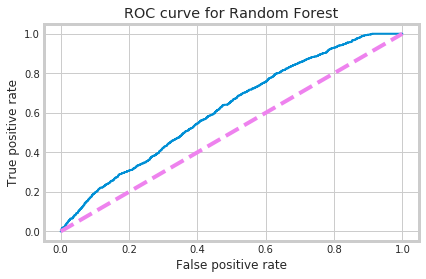

In [77]:
fpr, tpr, thresholds = roc_curve(ytest, rf_cv_best.predict_proba(X_test_scaled)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Random Forest');
print("ROC AUC score = ", roc_auc_score(ytest, rf_cv_best.predict_proba(X_test_scaled)[:,1]))


In [62]:
importances_dict = {}
for feature, importance in zip(Xtrain.columns, rf_cv_best.feature_importances_):
    importances_dict[feature] = importance
sorted(importances_dict.items(), key=lambda kv: kv[1], reverse=True)[0:10]


[('num_sessions', 0.13102348151330495),
 ('age', 0.12274688326940328),
 ('secs_elapsed_mean', 0.11478285959039244),
 ('secs_elapsed_std', 0.11246201183577213),
 ('num_different_actions', 0.09520395495374583),
 ('day_created', 0.051338254220175926),
 ('day_active', 0.048908822604266496),
 ('gender_male', 0.04394588087205578),
 ('month_created', 0.03645336179121312),
 ('month_active', 0.032688085306073277)]

In [64]:
features = pd.DataFrame([importances_dict]).transpose().reset_index()
features.columns = ['feature','importance']
features = features.sort_values(by='importance', ascending = False).reset_index(drop=True)
features[0:5]

,feature,importance
0,num_sessions,0.131023
1,age,0.122747
2,secs_elapsed_mean,0.114783
3,secs_elapsed_std,0.112462
4,num_different_actions,0.095204


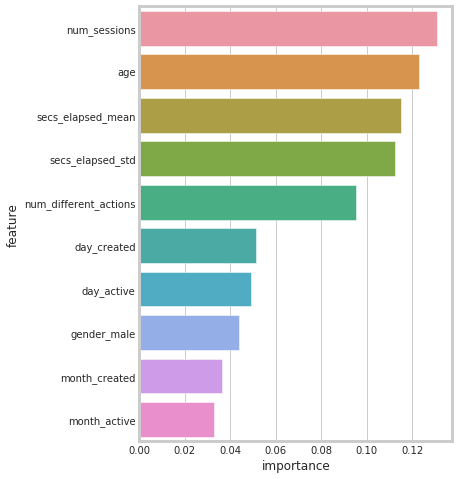

In [68]:
sns.set_style("whitegrid")
ftplot, ax = plt.subplots(figsize = (5,8))
ftplot = sns.barplot(y="feature", x="importance", 
            orient="h", data=features[0:10])
axes = ftplot.axes
#axes.set_xlim(-.02,.02);

['num_sessions',
 'age',
 'secs_elapsed_mean',
 'secs_elapsed_std',
 'num_different_actions']

***

### *d. Save to pickle*

In [55]:
# THE GRIDSEARCH RESULTS #
pkl_filename = 'models/rf_gridsearch_cv_20k.pkl'
# Open
gridcv_pkl = open(pkl_filename, 'wb')
# Insert object
pickle.dump(rf_cv, gridcv_pkl)
# Close
gridcv_pkl.close()

# THE MODEL WITH BEST PARAMS FIT ON SCALED TRAIN DATA #
pkl_filename_2 = 'models/rf_cv_20k.pkl'
# Open 
model_pkl = open(pkl_filename_2, 'wb')
# Insert object
pickle.dump(rf_cv_best, model_pkl)
# Close
model_pkl.close()

### *e. Pair plots of important features*

In [73]:
Xtrain.shape

(17092, 62)

In [74]:
cols1 = list(features.iloc[0:5,0])
cols1.append('country_USA_World_bi')
cols1

['num_sessions',
 'age',
 'secs_elapsed_mean',
 'secs_elapsed_std',
 'num_different_actions',
 'country_USA_World_bi']

/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


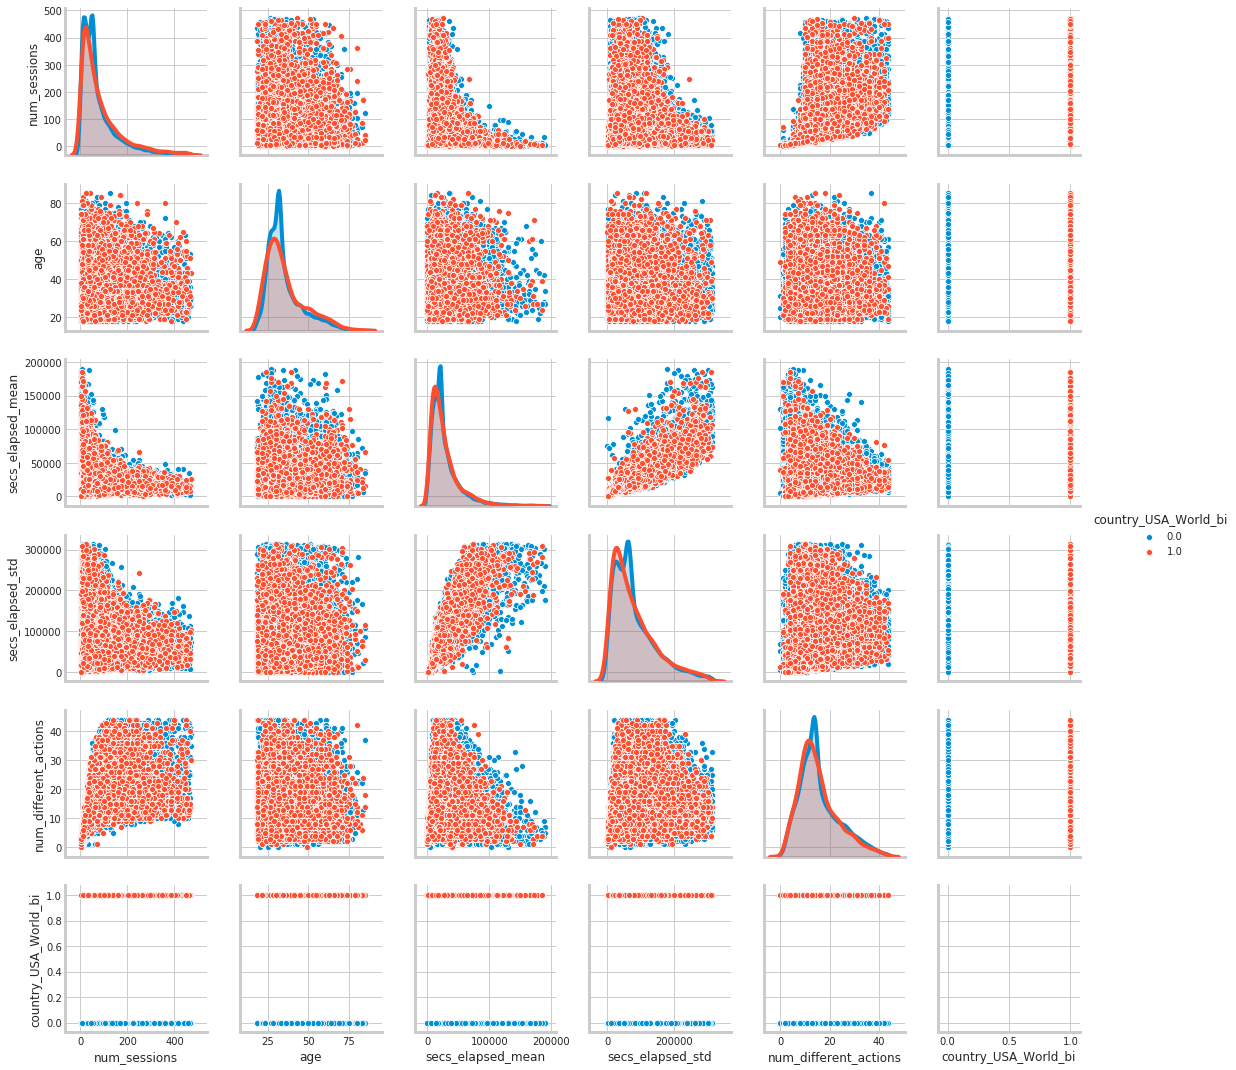

In [76]:
pairs = Xy[cols1]
sns.pairplot(pairs, hue='country_USA_World_bi')

***